In [1]:
device = "cpu"
for backend, device_name in {
    torch.backends.mps: "mps",
    torch.cuda: "cuda",
}.items():
    if backend.is_available():
        device = device_name

NameError: name 'torch' is not defined

In [5]:
#https://github.com/bitsbytes-maker/DeepGD-Demo/blob/master/deepgd_demo.ipynb
#https://github.com/bitsbytes-maker/deepgd
#https://github.com/yolandalalala/deepgd/tree/master/deepgd


import torch
import os

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
import random

import torch
import torch_geometric as pyg
from tqdm.auto import *


In [7]:
DATA_ROOT = "data"

import os
import re

import torch
import torch_geometric as pyg
import networkx as nx
import numpy as np


class RomeDataset(pyg.data.InMemoryDataset):
    def __init__(self, *,
                 url='http://www.graphdrawing.org/download/rome-graphml.tgz',
                 root=f'{DATA_ROOT}/Rome',
                 layout_initializer=None,
                 transform=None,
                 pre_transform=None,
                 pre_filter=None):
        self.url = url
        self.initializer = layout_initializer or nx.drawing.random_layout
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        metafile = "rome/Graph.log"
        if os.path.exists(metadata_path := f'{self.raw_dir}/{metafile}'):
            return list(map(lambda f: f'rome/{f}.graphml',
                            self.get_graph_names(metadata_path)))
        else:
            return [metafile]

    @property
    def processed_file_names(self):
        return ['data.pt']

    @classmethod
    def get_graph_names(cls, logfile):
        with open(logfile) as fin:
            for line in fin.readlines():
                if match := re.search(r'name: (grafo\d+\.\d+)', line):
                    yield f'{match.group(1)}'

    def process_raw(self):
        graphmls = sorted(self.raw_paths,
                          key=lambda x: int(re.search(r'grafo(\d+)', x).group(1)))
        for file in tqdm(graphmls, desc=f"Loading graphs"):
            G = nx.read_graphml(file)
            if nx.is_connected(G):
                yield nx.convert_node_labels_to_integers(G)

    def convert(self, G):
        apsp = dict(nx.all_pairs_shortest_path_length(G))
        init_pos = torch.tensor(np.array(list(self.initializer(G).values())))
        full_edges, attr_d = zip(*[((u, v), d) for u in apsp for v, d in apsp[u].items()])
        raw_edge_index = pyg.utils.to_undirected(torch.tensor(list(G.edges)).T)
        full_edge_index, d = pyg.utils.remove_self_loops(*pyg.utils.to_undirected(
            torch.tensor(full_edges).T, torch.tensor(attr_d)
        ))
        k = 1 / d ** 2
        full_edge_attr = torch.stack([d, k], dim=-1)
        return pyg.data.Data(
            G=G,
            x=init_pos,
            init_pos=init_pos,
            edge_index=full_edge_index,
            edge_attr=full_edge_attr,
            raw_edge_index=raw_edge_index,
            full_edge_index=full_edge_index,
            full_edge_attr=full_edge_attr,
            d=d,
            n=G.number_of_nodes(),
            m=G.number_of_edges(),
        )

    def download(self):
        pyg.data.download_url(self.url, self.raw_dir)
        pyg.data.extract_tar(f'{self.raw_dir}/rome-graphml.tgz', self.raw_dir)

    def process(self):
        data_list = map(self.convert, self.process_raw())

        if self.pre_filter is not None:
            data_list = filter(self.pre_filter, data_list)

        if self.pre_transform is not None:
            data_list = map(self.pre_transform, data_list)

        data, slices = self.collate(list(data_list))
        torch.save((data, slices), self.processed_paths[0])

In [8]:
dataset = RomeDataset()

Extracting data/Rome/raw/rome-graphml.tgz
Processing...


Loading graphs:   0%|          | 0/11534 [00:00<?, ?it/s]

Done!


In [9]:
from itertools import chain

import torch
from torch import nn
import torch_geometric as pyg

def l2_normalize(x, return_norm=False, eps=1e-5):
    if type(x) is torch.Tensor:
        norm = x.norm(dim=1).unsqueeze(dim=1)
    else:
        norm = np.linalg.norm(x, axis=1, keepdims=True)
    unit_vec = x / (norm + eps)
    if return_norm:
        return unit_vec, norm
    else:
        return unit_vec


def get_edges(node_pos, batch):
    edges = node_pos[batch.edge_index.T]
    return edges[:, 0, :], edges[:, 1, :]


def get_full_edges(node_pos, batch):
    edges = node_pos[batch.full_edge_index.T]
    return edges[:, 0, :], edges[:, 1, :]


def get_raw_edges(node_pos, batch):
    edges = node_pos[batch.raw_edge_index.T]
    return edges[:, 0, :], edges[:, 1, :]


def get_per_graph_property(batch, property_getter):
    return torch.tensor(list(map(property_getter, batch.to_data_list())),
                        device=batch.x.device)


def map_node_indices_to_graph_property(batch, node_index, property_getter):
    return get_per_graph_property(batch, property_getter)[batch.batch][node_index]


def map_node_indices_to_node_degrees(real_edges, node_indices):
    node, degrees = np.unique(real_edges[:, 0].detach().cpu().numpy(), return_counts=True)
    return torch.tensor(degrees[node_indices], device=real_edges.device)


def get_counter_clockwise_sorted_angle_vertices(edges, pos):
    if type(pos) is torch.Tensor:
        edges = edges.cpu().detach().numpy()
        pos = pos.cpu().detach().numpy()
    u, v = edges[:, 0], edges[:, 1]
    diff = pos[v] - pos[u]
    diff_normalized = l2_normalize(diff)
    # get cosine angle between uv and y-axis
    cos = diff_normalized @ np.array([[1],[0]])
    # get radian between uv and y-axis
    radian = np.arccos(cos) * np.expand_dims(np.sign(diff[:, 1]), axis=1)
    # for each u, sort edges based on the position of v
    sorted_idx = sorted(np.arange(len(edges)), key=lambda e: (u[e], radian[e]))
    sorted_v = v[sorted_idx]
    # get start index for each u
    idx = np.unique(u, return_index=True)[1]
    roll_idx = np.arange(1, len(u) + 1)
    roll_idx[np.roll(idx - 1, -1)] = idx
    rolled_v = sorted_v[roll_idx]
    return np.stack([u, sorted_v, rolled_v]).T[sorted_v != rolled_v]


def get_radians(pos, batch,
                return_node_degrees=False,
                return_node_indices=False,
                return_num_nodes=False,
                return_num_real_edges=False):
    real_edges = batch.raw_edge_index.T
    angles = get_counter_clockwise_sorted_angle_vertices(real_edges, pos)
    u, v1, v2 = angles[:, 0], angles[:, 1], angles[:, 2]
    e1 = l2_normalize(pos[v1] - pos[u])
    e2 = l2_normalize(pos[v2] - pos[u])
    radians = (e1 * e2).sum(dim=1).acos()
    result = (radians,)
    if return_node_degrees:
        degrees = map_node_indices_to_node_degrees(real_edges, u)
        result += (degrees,)
    if return_node_indices:
        result += (u,)
    if return_num_nodes:
        node_counts = map_node_indices_to_graph_property(batch, angles[:,0], lambda g: g.num_nodes)
        result += (node_counts,)
    if return_num_real_edges:
        edge_counts = map_node_indices_to_graph_property(batch, angles[:,0], lambda g: len(g.raw_edge_index.T))
        result += (edge_counts,)
    return result[0] if len(result) == 1 else result

def generate_rand_pos(n, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    return torch.rand(n, 2).mul(2).sub(1)

class GNNLayer(nn.Module):
    def __init__(self,
                 nfeat_dims,
                 efeat_dim,
                 aggr,
                 edge_net=None,
                 dense=False,
                 bn=True,
                 act=True,
                 dp=None,
                 root_weight=True,
                 skip=True):
        super().__init__()
        try:
            in_dim = nfeat_dims[0]
            out_dim = nfeat_dims[1]
        except:
            in_dim = nfeat_dims
            out_dim = nfeat_dims
        self.enet = nn.Linear(efeat_dim, in_dim * out_dim) if edge_net is None and efeat_dim > 0 else edge_net
        self.conv = pyg.nn.NNConv(in_dim, out_dim, nn=self.enet, aggr=aggr, root_weight=root_weight)
        self.dense = nn.Linear(out_dim, out_dim) if dense else nn.Identity()
        self.bn = pyg.nn.BatchNorm(out_dim) if bn else nn.Identity()
        self.act = nn.LeakyReLU() if act else nn.Identity()
        self.dp = dp and nn.Dropout(dp) or nn.Identity()
        self.skip = skip
        self.proj = nn.Linear(in_dim, out_dim, bias=False) if in_dim != out_dim else nn.Identity()

    def forward(self, v, e, data):
        v_ = v
        v = self.conv(v, data.edge_index, e)
        v = self.dense(v)
        v = self.bn(v)
        v = self.act(v)
        v = self.dp(v)
        return v + self.proj(v_) if self.skip else v

class GNNBlock(nn.Module):
    def __init__(self,
                 feat_dims,
                 efeat_hid_dims=[],
                 efeat_hid_act=nn.LeakyReLU,
                 efeat_out_act=nn.Tanh,
                 bn=False,
                 act=True,
                 dp=None,
                 aggr='mean',
                 root_weight=True,
                 static_efeats=2,
                 dynamic_efeats='skip',
                 euclidian=False,
                 direction=False,
                 n_weights=0,
                 residual=False):
        '''
        dynamic_efeats: {
            skip: block input to each layer,
            first: block input to first layer,
            prev: previous layer output to next layer,
            orig: original node feature to each layer
        }
        '''
        super().__init__()
        self.static_efeats = static_efeats
        self.dynamic_efeats = dynamic_efeats
        self.euclidian = euclidian
        self.direction = direction
        self.n_weights = n_weights
        self.residual = residual
        self.gnn = nn.ModuleList()
        self.n_layers = len(feat_dims) - 1

        for idx, (in_feat, out_feat) in enumerate(zip(feat_dims[:-1], feat_dims[1:])):
            direction_dim = (feat_dims[idx] if self.dynamic_efeats == 'prev'
                             else 2 if self.dynamic_efeats == 'orig'
                             else feat_dims[0])
            in_efeat_dim = self.static_efeats
            if self.dynamic_efeats != 'first':
                in_efeat_dim += self.euclidian + self.direction * direction_dim + self.n_weights
            edge_net = nn.Sequential(*chain.from_iterable(
                [nn.Linear(idim, odim),
                 nn.BatchNorm1d(odim),
                 act()]
                for idim, odim, act in zip([in_efeat_dim] + efeat_hid_dims,
                                           efeat_hid_dims + [in_feat * out_feat],
                                           [efeat_hid_act] * len(efeat_hid_dims) + [efeat_out_act])
            ))
            self.gnn.append(GNNLayer(nfeat_dims=(in_feat, out_feat),
                                     efeat_dim=in_efeat_dim,
                                     edge_net=edge_net,
                                     bn=bn,
                                     act=act,
                                     dp=dp,
                                     aggr=aggr,
                                     root_weight=root_weight,
                                     skip=False))

    def _get_edge_feat(self, pos, data, euclidian=False, direction=False, weights=None):
        e = data.edge_attr[:, :self.static_efeats]
        if euclidian or direction:
            start_pos, end_pos = get_edges(pos, data)
            v, u = l2_normalize(end_pos - start_pos, return_norm=True)
            if euclidian:
                e = torch.cat([e, u], dim=1)
            if direction:
                e = torch.cat([e, v], dim=1)
        if weights is not None:
            w = weights.repeat(len(e), 1)
            e = torch.cat([e, w], dim=1)
        return e

    def forward(self, v, data, weights=None):
        vres = v
        for layer in range(self.n_layers):
            vsrc = (v if self.dynamic_efeats == 'prev'
                    else data.pos if self.dynamic_efeats == 'orig'
                    else vres)
            get_extra = not (self.dynamic_efeats == 'first' and layer != 0)
            e = self._get_edge_feat(vsrc, data,
                                    euclidian=self.euclidian and get_extra,
                                    direction=self.direction and get_extra,
                                    weights=weights if get_extra and self.n_weights > 0 else None)
            v = self.gnn[layer](v, e, data)
        return v + vres if self.residual else v

class DeepGD(nn.Module):
    def __init__(self,
                 num_blocks=9,
                 num_layers=3,
                 num_enet_layers=2,
                 layer_dims=None,
                 n_weights=0,
                 dynamic_efeats='skip',
                 euclidian=True,
                 direction=True,
                 residual=True,
                 normalize=None):
        super().__init__()

        self.in_blocks = nn.ModuleList([
            GNNBlock(feat_dims=[2, 8, 8 if layer_dims is None else layer_dims[0]], bn=True, dp=0.2, static_efeats=2)
        ])
        self.hid_blocks = nn.ModuleList([
            GNNBlock(feat_dims=layer_dims or ([8] + [8] * num_layers),
                     efeat_hid_dims=[16] * (num_enet_layers - 1),
                     bn=True,
                     act=True,
                     dp=0.2,
                     static_efeats=2,
                     dynamic_efeats=dynamic_efeats,
                     euclidian=euclidian,
                     direction=direction,
                     n_weights=n_weights,
                     residual=residual)
            for _ in range(num_blocks)
        ])
        self.out_blocks = nn.ModuleList([
            GNNBlock(feat_dims=[8 if layer_dims is None else layer_dims[-1], 8], bn=True, static_efeats=2),
            GNNBlock(feat_dims=[8, 2], act=False, static_efeats=2)
        ])
        self.normalize = normalize

    def forward(self, data, weights=None, output_hidden=False, numpy=False):
        v = data.init_pos if data.init_pos is not None else generate_rand_pos(len(data.x)).to(data.x.device)
        if self.normalize is not None:
            v = self.normalize(v, data)

        hidden = []
        for block in chain(self.in_blocks,
                           self.hid_blocks,
                           self.out_blocks):
            v = block(v, data, weights)
            if output_hidden:
                hidden.append(v.detach().cpu().numpy() if numpy else v)
        if not output_hidden:
            vout = v.detach().cpu().numpy() if numpy else v
            if self.normalize is not None:
                vout = self.normalize(vout, data)

        return hidden if output_hidden else vout


In [10]:
model = DeepGD().to(device)

In [11]:
import torch_scatter

class EdgeVar(nn.Module):
    def __init__(self, reduce=torch.mean):
        super().__init__()
        self.reduce = reduce

    def forward(self, node_pos, batch):
        edge_idx = batch.raw_edge_index.T
        start, end = get_raw_edges(node_pos, batch)
        eu = end.sub(start).norm(dim=1)
        edge_var = eu.sub(1).square()
        index = batch.batch[batch.raw_edge_index[0]]
        graph_var = torch_scatter.scatter(edge_var, index, reduce="mean")
        return graph_var if self.reduce is None else self.reduce(graph_var)

class IncidentAngle(nn.Module):
    def __init__(self, reduce=torch.mean):
        super().__init__()
        self.reduce = reduce

    def forward(self, node_pos, batch):
        theta, degrees, indices = get_radians(node_pos, batch,
                                              return_node_degrees=True,
                                              return_node_indices=True)
        phi = degrees.float().pow(-1).mul(2*np.pi)
        angle_l1 = phi.sub(theta).abs()
        index = batch.batch[indices]
        graph_l1 = torch_scatter.scatter(angle_l1, index)
        return graph_l1 if self.reduce is None else self.reduce(graph_l1)

class Occlusion(nn.Module):
    def __init__(self, gamma=1, reduce=torch.mean):
        super().__init__()
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, node_pos, batch):
        start, end = get_full_edges(node_pos, batch)
        eu = end.sub(start).norm(dim=1)
        edge_occusion = eu.mul(-self.gamma).exp()
        index = batch.batch[batch.edge_index[0]]
        graph_occusion = torch_scatter.scatter(edge_occusion, index)
        return graph_occusion if self.reduce is None else self.reduce(graph_occusion)

class Stress(nn.Module):
    def __init__(self, reduce=torch.mean):
        super().__init__()
        self.reduce = reduce

    def forward(self, node_pos, batch):
        # print(node_pos)
        # print(batch)
        start, end = get_full_edges(node_pos, batch)
        eu = (start - end).norm(dim=1)
        d = batch.full_edge_attr[:, 0]
        edge_stress = eu.sub(d).abs().div(d).square()
        index = batch.batch[batch.edge_index[0]]
        graph_stress = torch_scatter.scatter(edge_stress, index)
        return graph_stress if self.reduce is None else self.reduce(graph_stress)

class TSNEScore(nn.Module):
    def __init__(self, sigma=1, reduce=torch.mean):
        super().__init__()
        self.sigma = sigma
        self.reduce = reduce

    def forward(self, node_pos, batch):
        p = batch.full_edge_attr[:, 0].div(-2 * self.sigma**2).exp()
        sum_src = torch_scatter.scatter(p, batch.full_edge_index[0])[batch.full_edge_index[0]]
        sum_dst = torch_scatter.scatter(p, batch.full_edge_index[1])[batch.full_edge_index[1]]
        p = (p / sum_src + p / sum_dst) / (2 * batch.n[batch.batch[batch.edge_index[0]]])
        start, end = get_full_edges(node_pos, batch)
        eu = end.sub(start).norm(dim=1)
        index = batch.batch[batch.full_edge_index[0]]
        q = 1 / (1 + eu.square())
        q /= torch_scatter.scatter(q, index)[index]
        edge_kl = (p.log() - q.log()).mul(p)
        graph_kl = torch_scatter.scatter(edge_kl, index)
        return graph_kl if self.reduce is None else self.reduce(graph_kl)

In [13]:
criteria = {
    Stress(): 1,
    EdgeVar(): 0,
    Occlusion(): 0,
    IncidentAngle(): 0,
    TSNEScore(): 0,
}
optim = torch.optim.AdamW(model.parameters())

In [14]:
datalist = list(dataset[:120])
random.seed(12345)
random.shuffle(datalist)

In [15]:
batch_size = 32

In [16]:
#train_loader = pyg.loader.DataLoader(datalist[:10000], batch_size=batch_size, shuffle=True)
#val_loader = pyg.loader.DataLoader(datalist[11000:], batch_size=batch_size, shuffle=False)
#test_loader = pyg.loader.DataLoader(datalist[10000:11000], batch_size=batch_size, shuffle=False)
train_loader = pyg.loader.DataLoader(datalist[:100], batch_size=batch_size, shuffle=True)
val_loader = pyg.loader.DataLoader(datalist[110:120], batch_size=batch_size, shuffle=False)
test_loader = pyg.loader.DataLoader(datalist[100:110], batch_size=batch_size, shuffle=False)

In [17]:
for epoch in range(1):
# for epoch in range(10):
# for epoch in range(100):
    model.train()
    losses = []
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        model.zero_grad()
        loss = 0
        for c, w in criteria.items():
            loss += w * c(model(batch), batch)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    print(f'[Epoch {epoch}] Train Loss: {np.mean(losses)}')
    with torch.no_grad():
        model.eval()
        losses = []
        for batch in tqdm(val_loader, disable=True):
            batch = batch.to(device)
            #loss = criterion(model(batch), batch)
            loss = 0
            for c, w in criteria.items():
              loss += w * c(model(batch), batch)
            losses.append(loss.item())
        print(f'[Epoch {epoch}] Val Loss: {np.mean(losses)}')

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 0] Train Loss: 490.3001022338867
[Epoch 0] Val Loss: 392.78192138671875


Number of components: 10
Spring embedding:


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


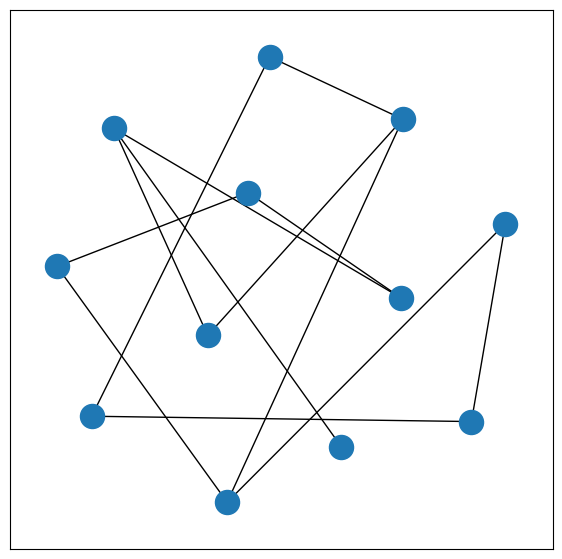

Model output:


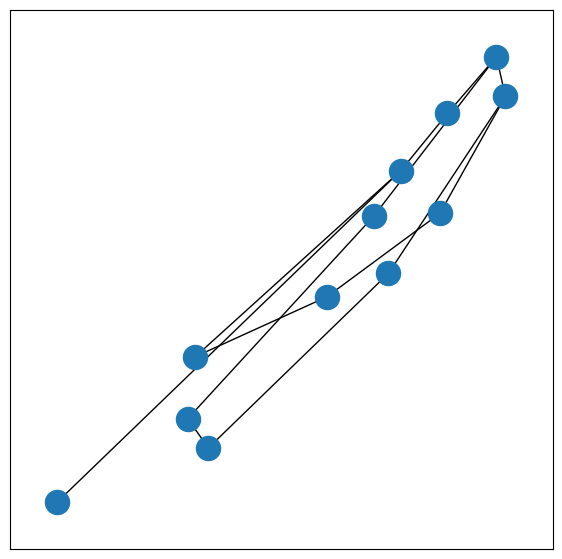

Spring embedding:


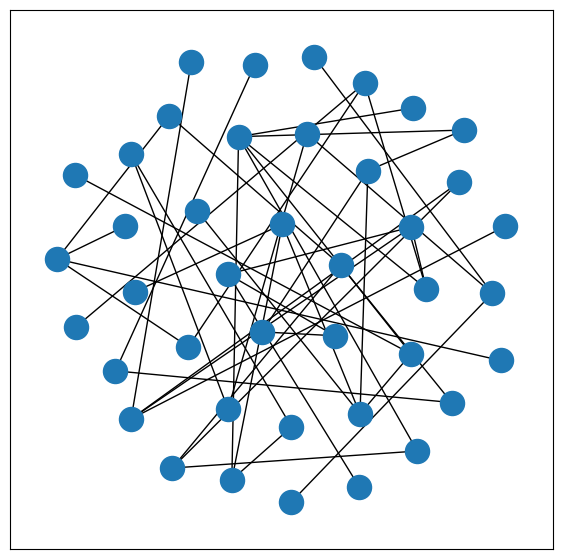

Model output:


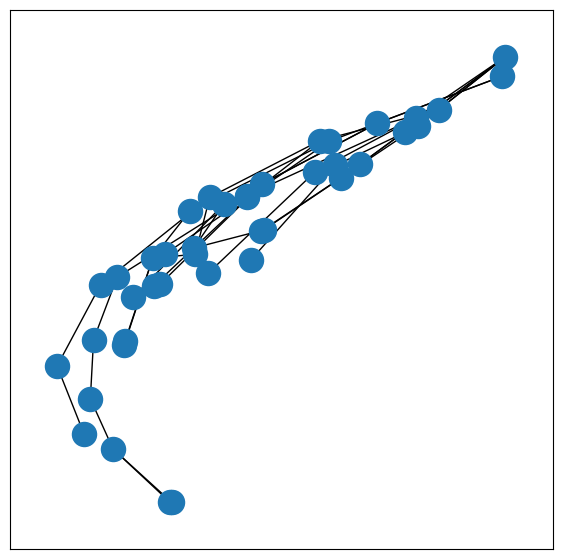

Spring embedding:


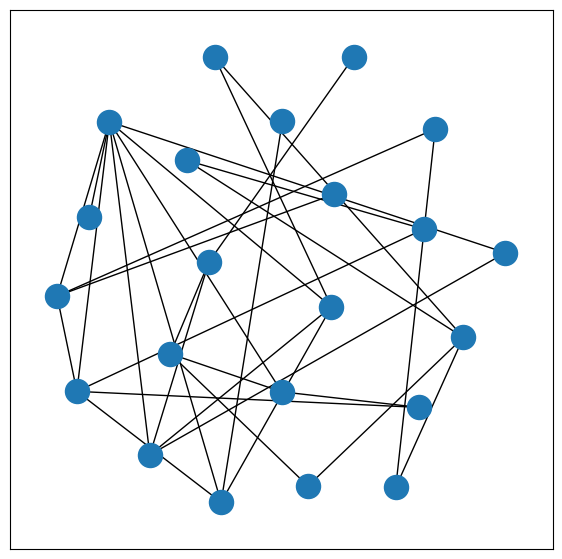

Model output:


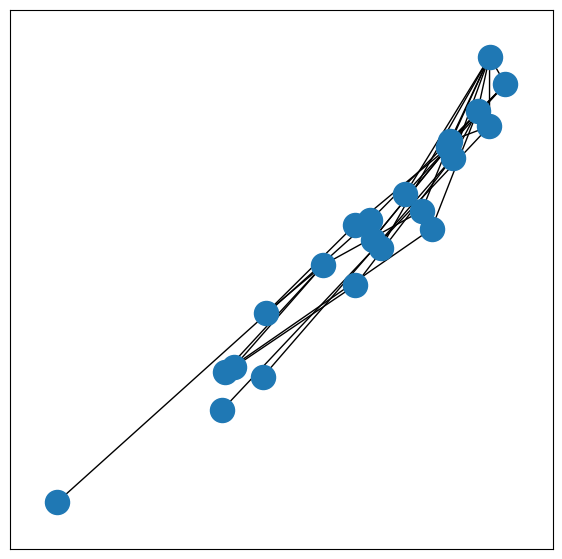

Spring embedding:


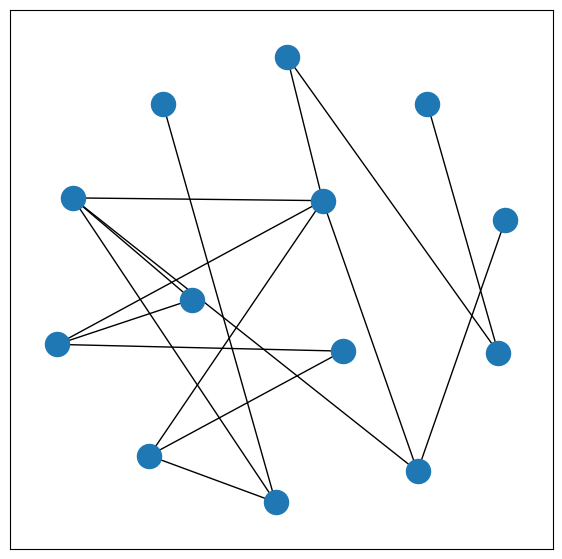

Model output:


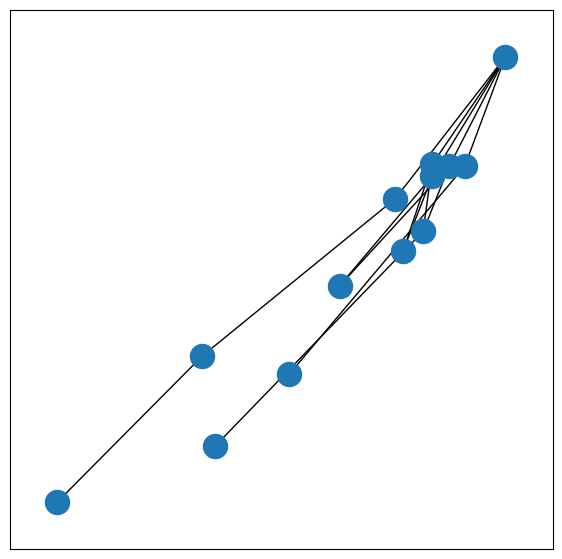

Spring embedding:


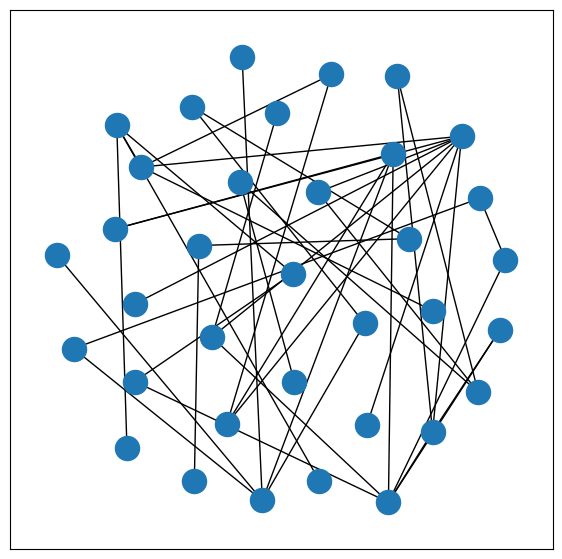

Model output:


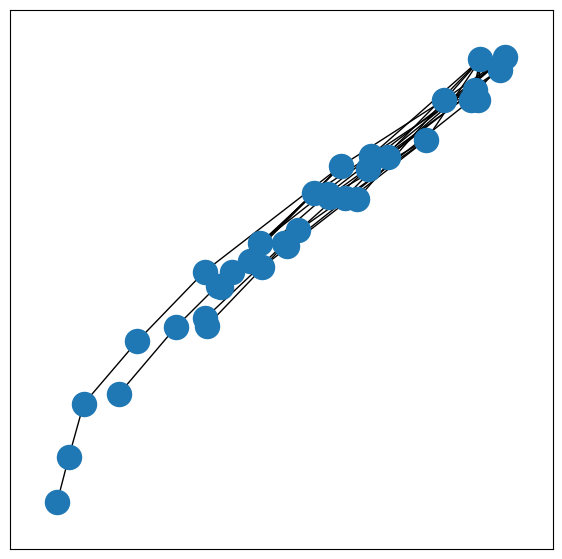

Spring embedding:


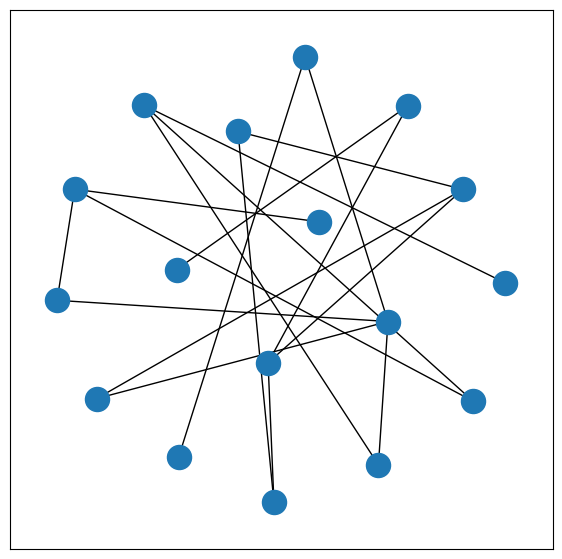

Model output:


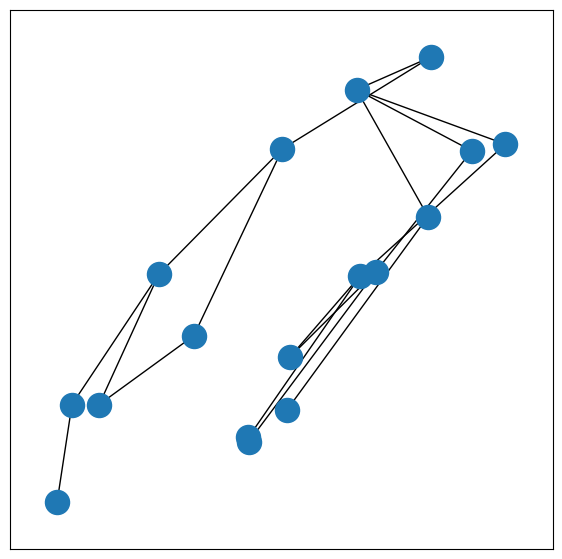

Spring embedding:


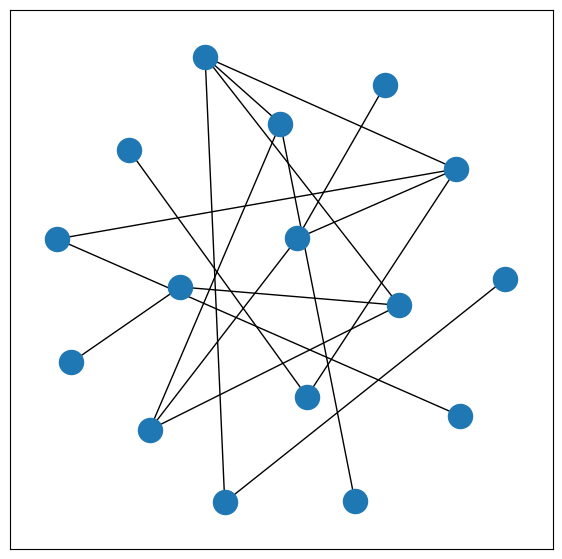

Model output:


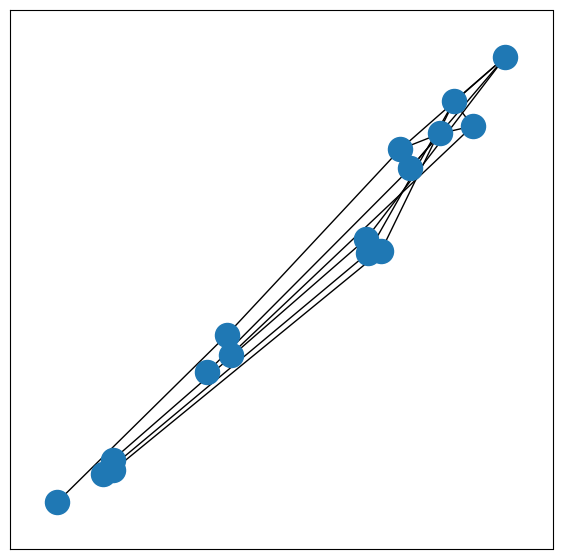

Spring embedding:


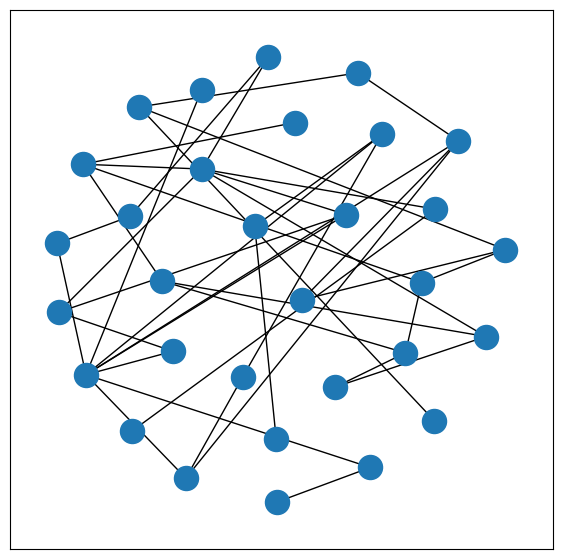

Model output:


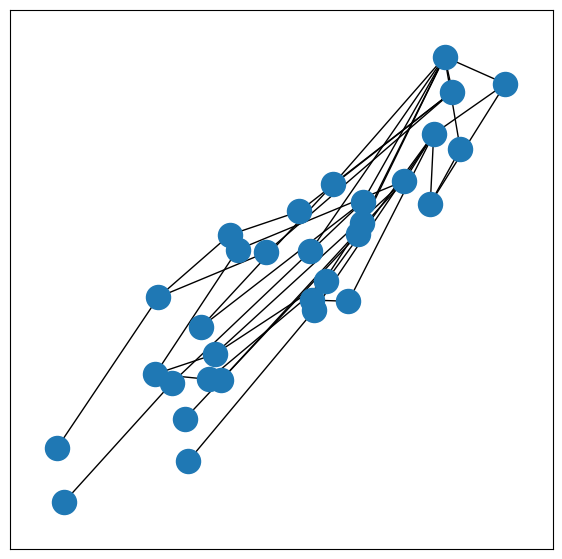

Spring embedding:


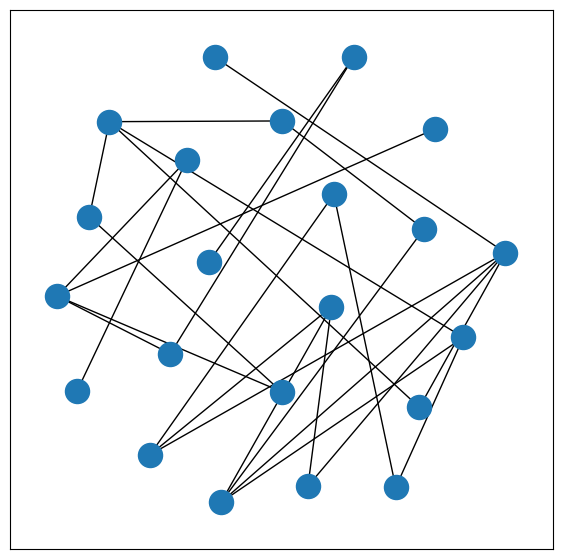

Model output:


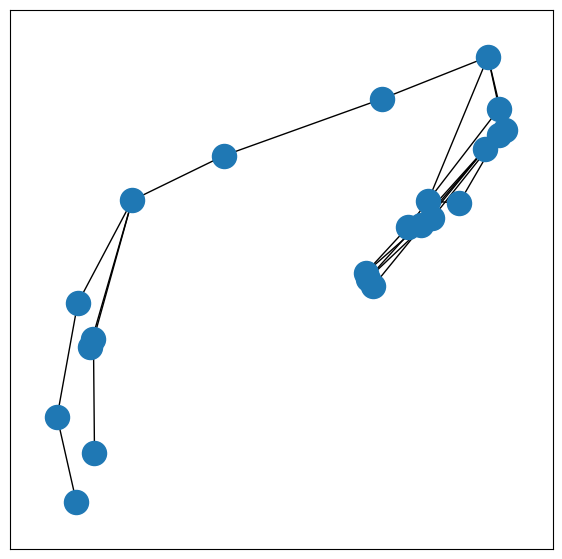

Spring embedding:


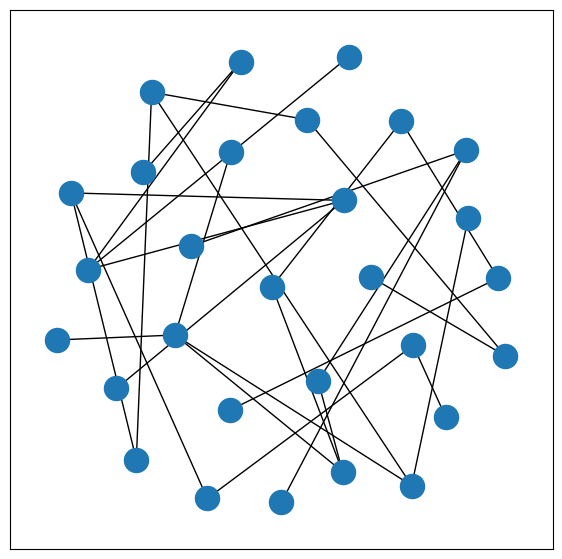

Model output:


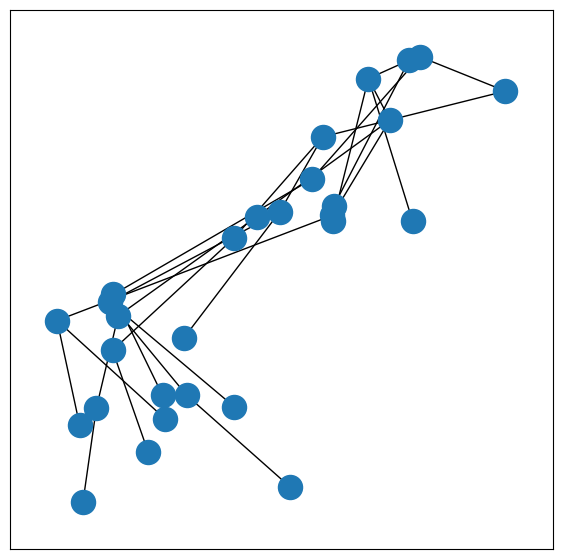

In [18]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(G, rei, pos=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    g2 = nx.Graph()
    for n in G.nodes():
      g2.add_node(n)
    #print(rei.shape)
    edge_list = []
    for i in range(rei.shape[1]):
      edge_list.append((rei[0][i], rei[1][i]))
    #print(edge_list)
    for u in G.nodes():
      for v in G.nodes():
        if u<v:
          if (u,v) in edge_list:
            g2.add_edge(u,v)
    if pos==None:
      nx.draw_networkx(g2, pos=nx.spring_layout(G, seed=42), with_labels=False, cmap="Set2")
      #print("spring positions:", nx.spring_layout(G, seed=42))
    else:
      nx.draw_networkx(g2, pos=pos, with_labels=False, cmap="Set2")
    plt.show()

#G = to_networkx(data, to_undirected=True)
#visualize_graph(G, color=data.y)

with torch.no_grad():
  model.eval()
  for batch in tqdm(test_loader, disable=True):
    batch = batch.to(device)
    #print(type(batch), batch)
    rei = batch.raw_edge_index.numpy()
    G = to_networkx(batch, to_undirected=True)
    CCs = list(nx.connected_components(G))
    print("Number of components:", len(CCs))
    out = model(batch)
    pos = dict()
    for i, x in enumerate(out):
      pos[i] = x.cpu().detach().numpy()
    for cc in CCs:
      cur_G = nx.induced_subgraph(G, cc)
      #print("Nodes:", cur_G.nodes())
      #print("pos:", pos)
      print("Spring embedding:")
      visualize_graph(cur_G,rei)
      print("Model output:")
      visualize_graph(cur_G, rei, pos)
    #print(type(out), out.shape, out)

Challenge:
1. run the model >> train on small graphs
2. Rome Graphs.
3. 10,000 graphs dataset but very small, smaller mount of times
4. train new loss function


DDL: End of May

Email:
1. spreadsheet
2. The result (100 epochs)
3. Subtmit in GD, run the experiment on smaller graph, because I cannot get models from graphs. Run experiments and submit on The 32nd International Symposium on Graph Drawing and Network Visualization.
